<a href="https://colab.research.google.com/github/JennaKvasnovsky/Fall2023/blob/main/WorkingAlexnet_Jenna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install wandb
!apt-get install poppler-utils
!pip install pdf2image
!pip install flashtorch
import requests
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from torchvision import *
from torchvision.models import *
import wandb as wb

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=device)

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=device)

def plot(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(5, 5)
    plt.show()

def get_google_slide(url):
    url_head = "https://docs.google.com/presentation/d/"
    url_body = url.split('/')[5]
    page_id = url.split('.')[-1]
    return url_head + url_body + "/export/pdf?id=" + url_body + "&pageid=" + page_id

def get_slides(url):
    url = get_google_slide(url)
    r = requests.get(url, allow_redirects=True)
    open('file.pdf', 'wb').write(r.content)
    images = convert_from_path('file.pdf', 500)
    return images

def load(image, size=224):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
    tensor = transform(image).unsqueeze(0).to(device)
    tensor.requires_grad = True
    return tensor



In [ ]:
labels = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}

model = alexnet(weights='DEFAULT').to(device)
model.eval();

In [ ]:
url = "https://docs.google.com/presentation/d/1P_SJyFD2T1dBIo7C5eS7BZhzM3oI8yHUfe7kvX1KITw/edit#slide=id.g206f8279a60_0_0"

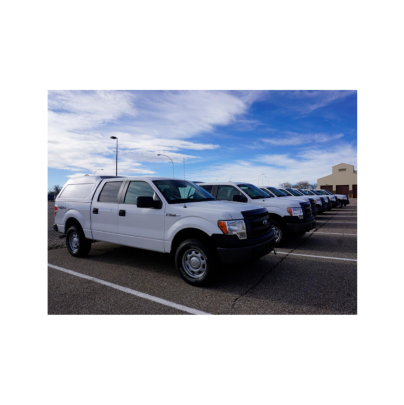

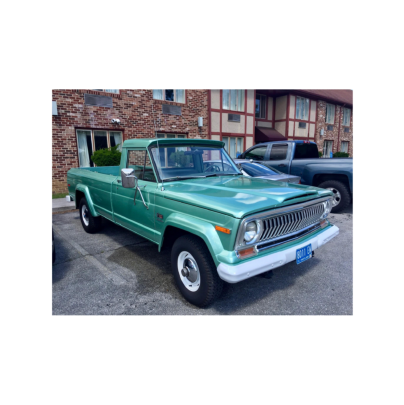

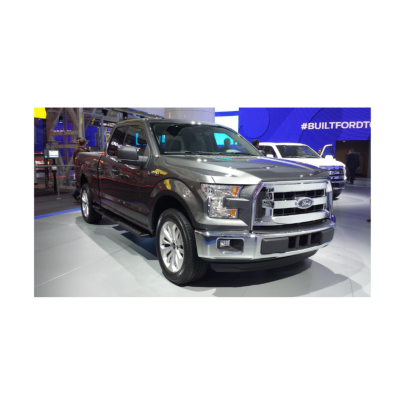

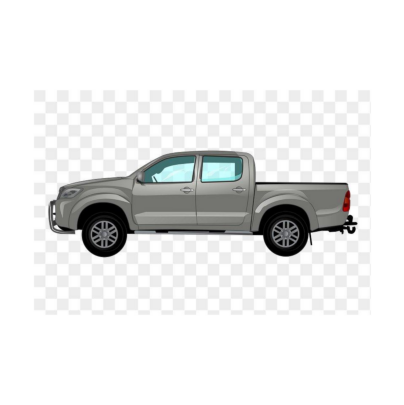

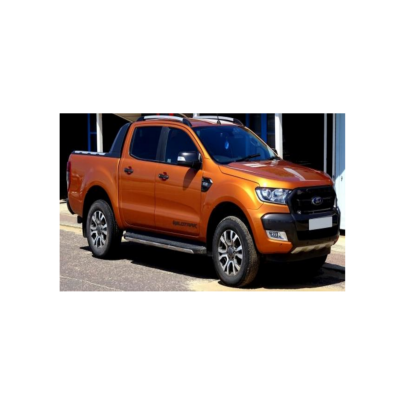

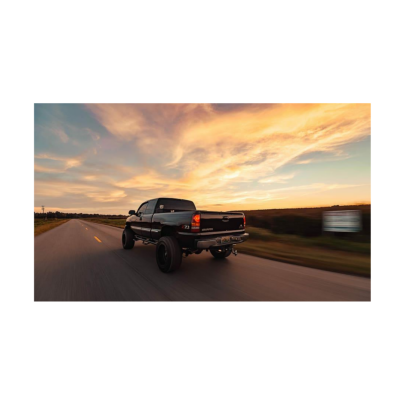

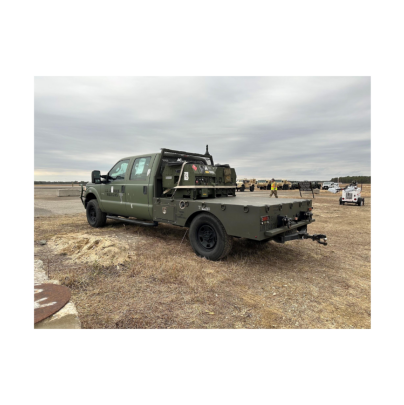

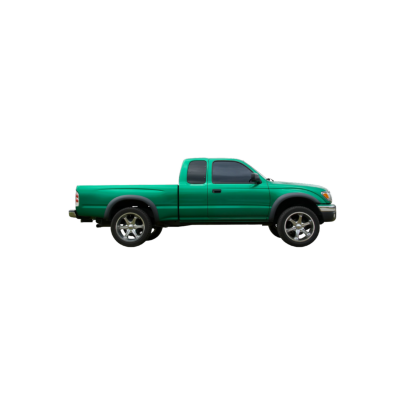

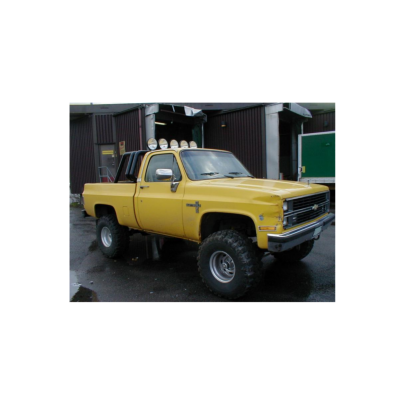

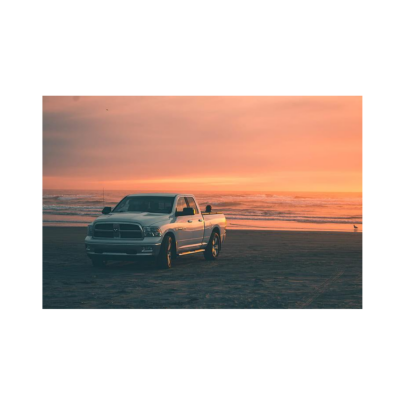

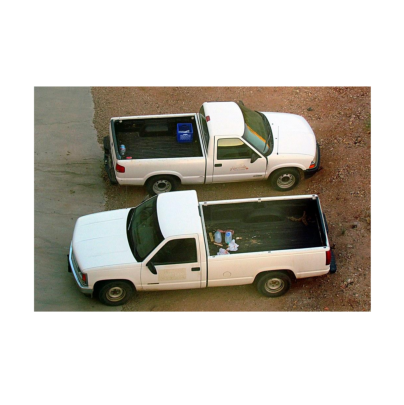

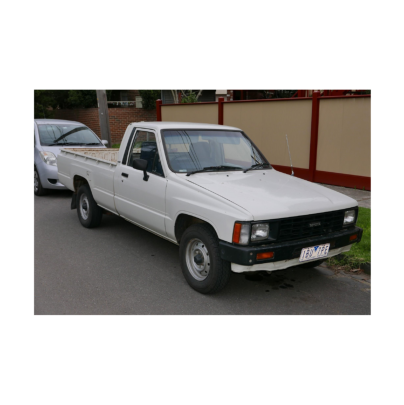

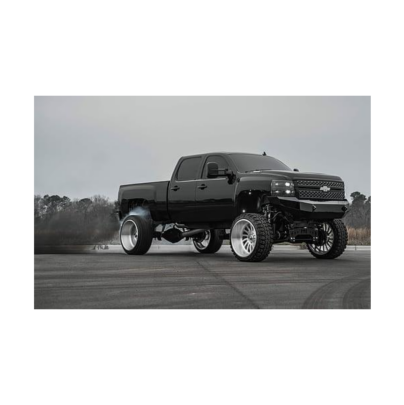

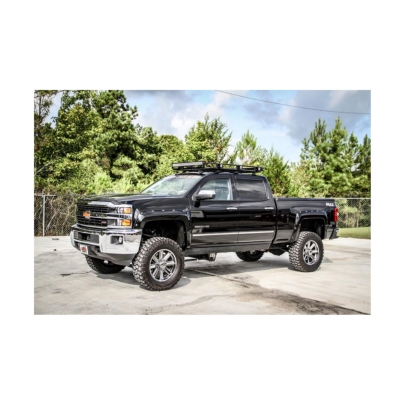

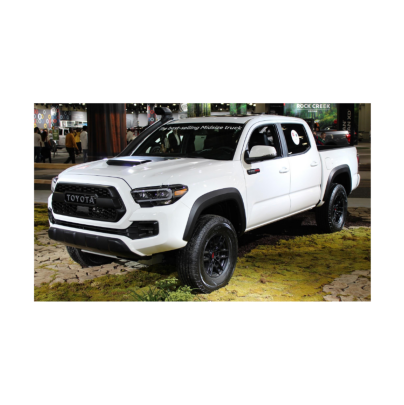

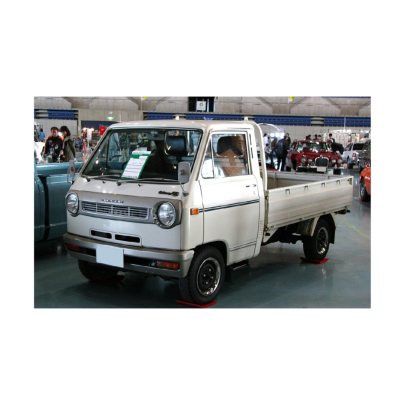

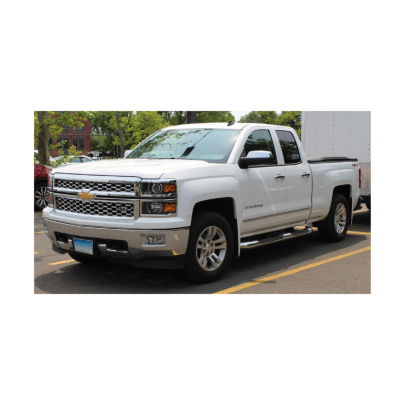

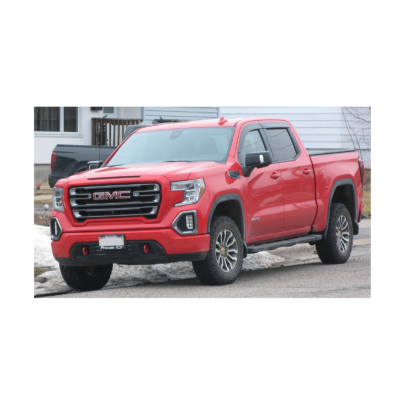

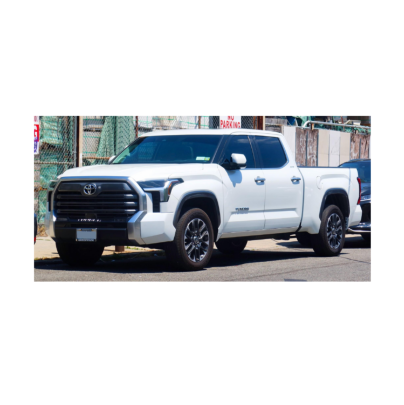

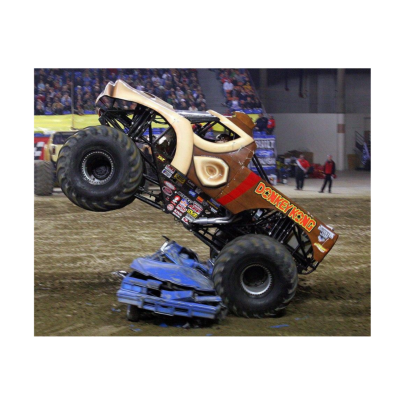

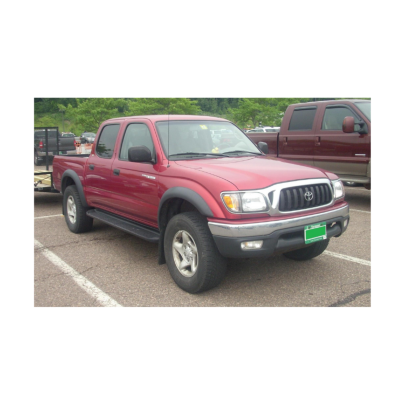

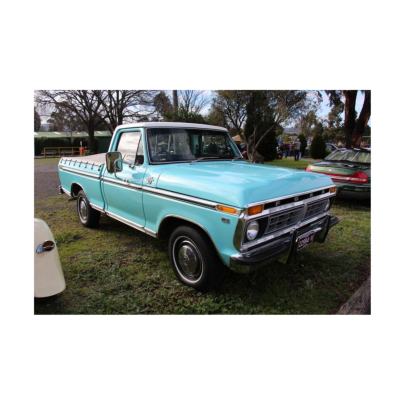

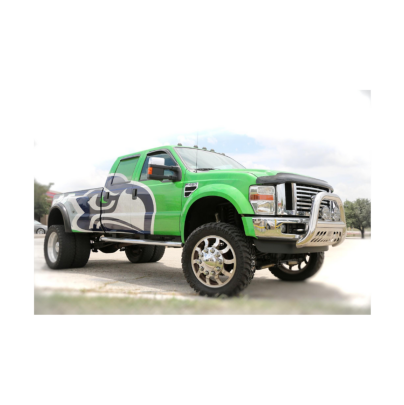

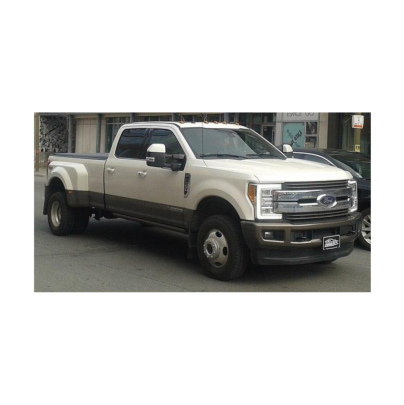

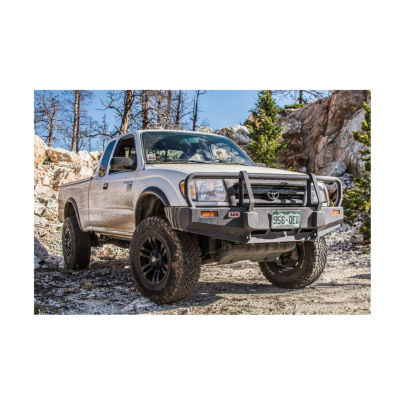

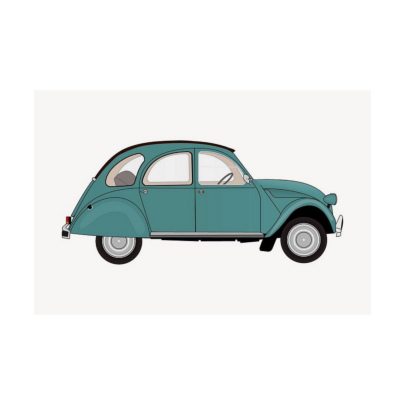

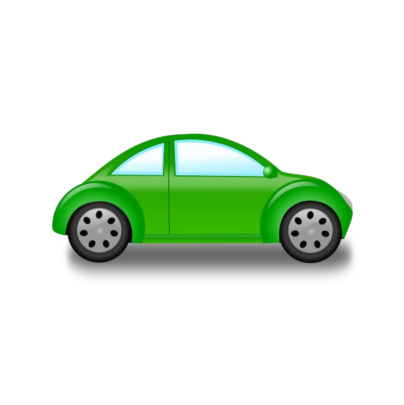

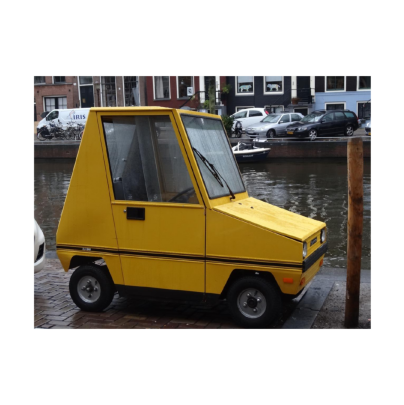

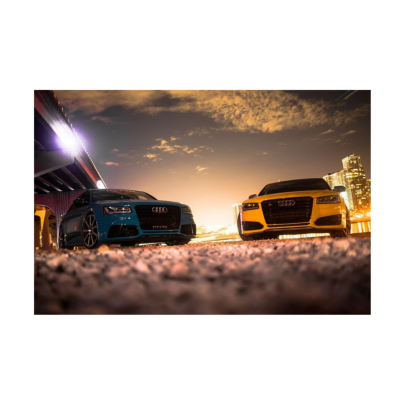

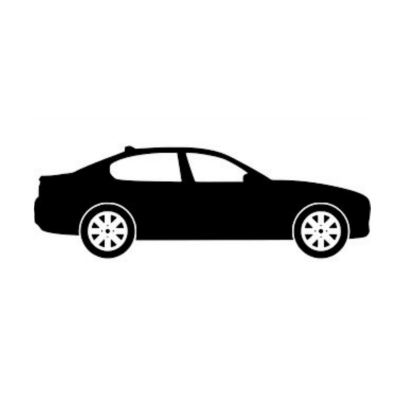

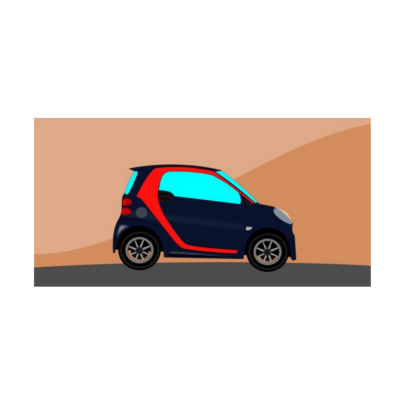

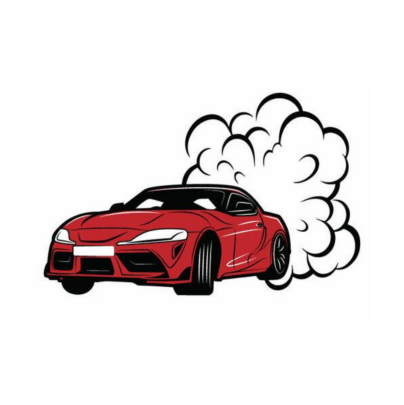

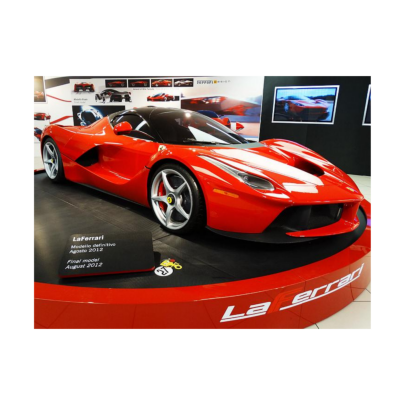

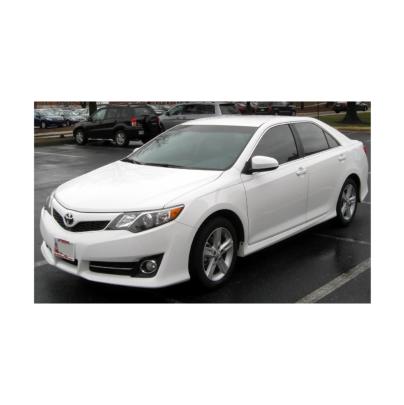

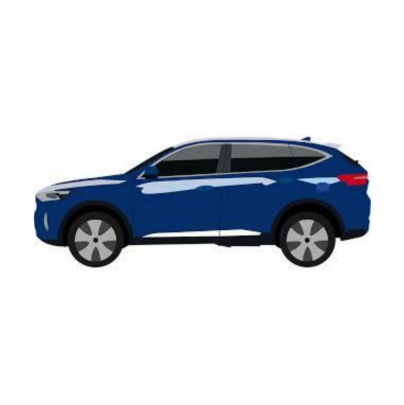

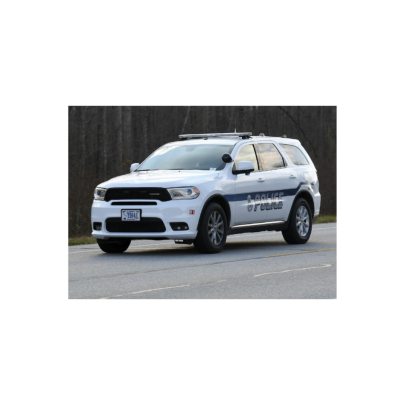

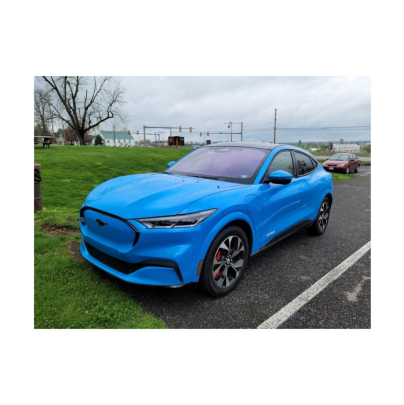

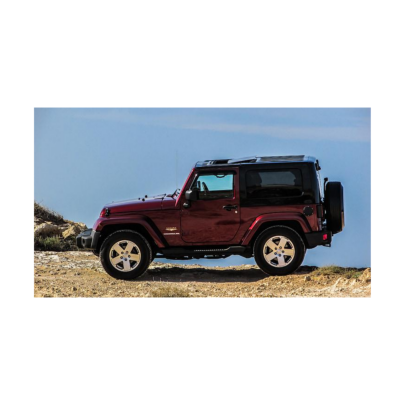

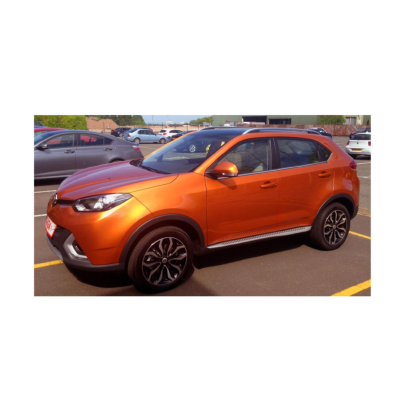

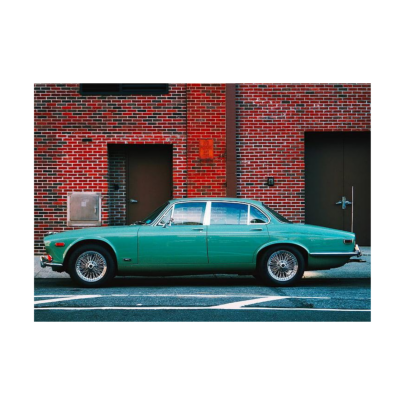

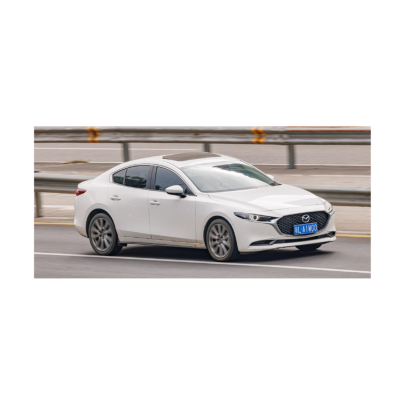

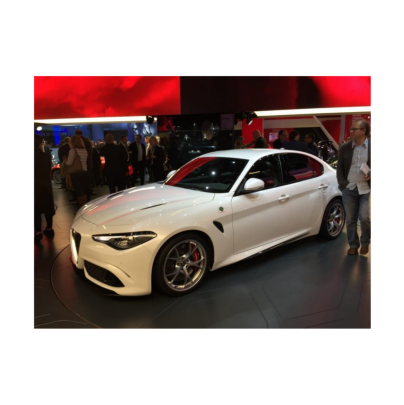

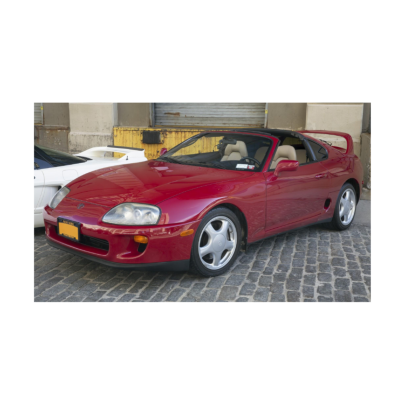

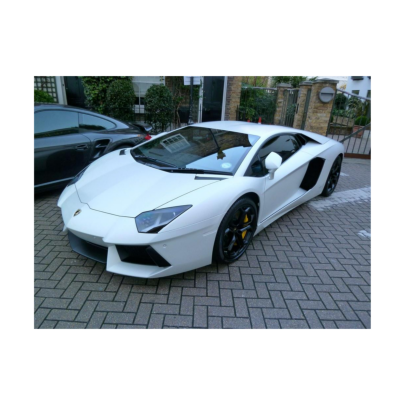

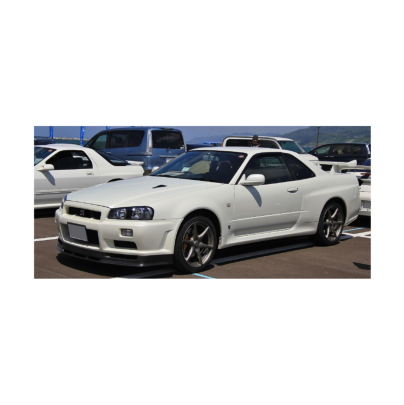

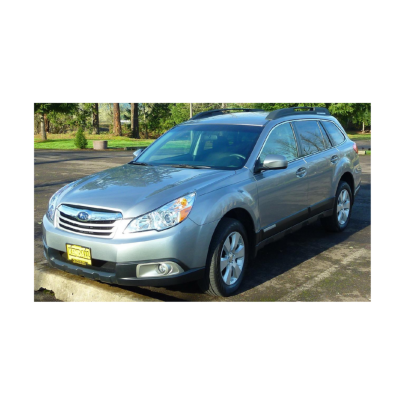

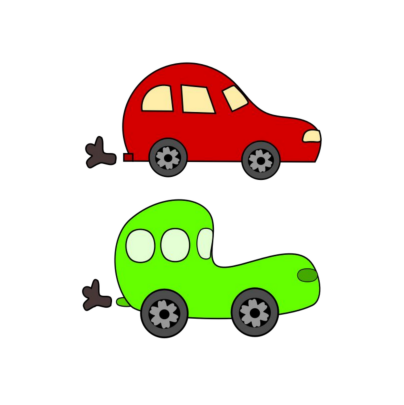

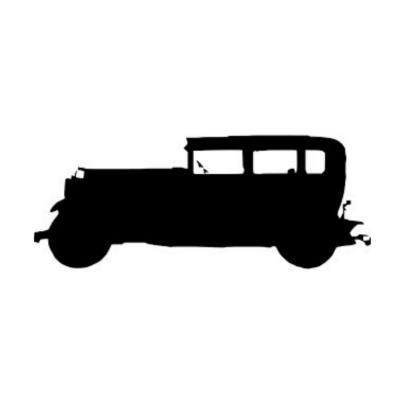

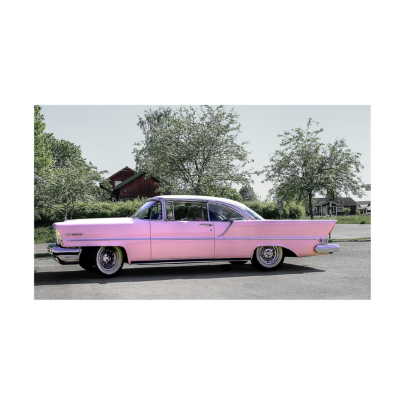

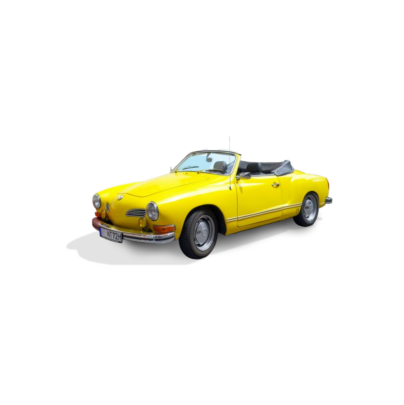

In [ ]:
images = []

for image in get_slides(url):

    plot(image)

    images.append(load(image))

images = torch.vstack(images)

In [ ]:
images.shape

torch.Size([50, 3, 224, 224])

In [ ]:
model(images)

tensor([[-1.8387, -4.6099, -2.5290,  ..., -6.4478, -1.3830,  0.3067],
        [-2.8485, -3.2756, -1.6175,  ..., -4.4444,  0.5257,  0.2311],
        [-3.3803, -5.6754, -4.0024,  ..., -5.7916,  0.0400,  0.5400],
        ...,
        [ 0.1619, -5.5118, -1.7651,  ..., -3.7392,  0.0283,  2.6178],
        [-1.3317, -3.3512, -2.6729,  ..., -5.3130,  0.2618,  0.1518],
        [-2.8197, -4.6152,  0.3467,  ..., -3.8842,  3.6705,  3.6442]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
y = model(images)

In [ ]:
y.shape

torch.Size([50, 1000])

In [ ]:
guesses = torch.argmax(y, 1).cpu().numpy()

In [ ]:
for i in list(guesses):
    print(labels[i])

limousine, limo
pickup, pickup truck
jeep, landrover
barbell
pickup, pickup truck
mousetrap
half track
power drill
snowplow, snowplough
chest
Polaroid camera, Polaroid Land camera
limousine, limo
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi
Model T
limousine, limo
jeep, landrover
moving van
pickup, pickup truck
racer, race car, racing car
go-kart
pickup, pickup truck
pickup, pickup truck
racer, race car, racing car
limousine, limo
jeep, landrover
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
whistle
moving van
fountain pen
hook, claw
car wheel
whistle
sports car, sport car
limousine, limo
sports car, sport car
racer, race car, racing car
racer, race car, racing car
Model T
sports car, sport car
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
convertible
limousine, limo
convertible
running shoe
limousine, limo
sports car, sport car
hair slide
muzzle
limousine, limo
cab, hack, taxi, ta

In [ ]:
#Y = np.zeros(100,)
#Y[50:] = 1

In [ ]:
Y = np.zeros(50,)
Y[25:] = 1

In [ ]:
X = y.detach().cpu().numpy()

In [ ]:
X.shape

(50, 1000)

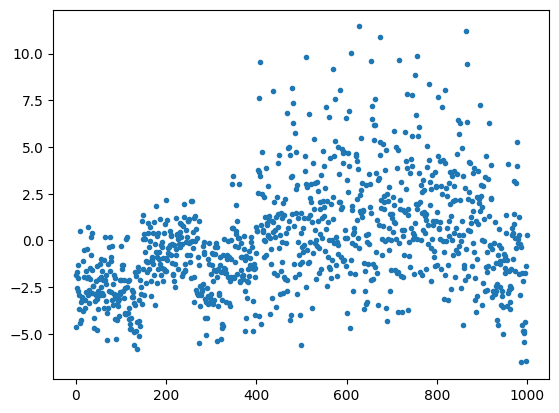

In [ ]:
plt.plot(X[0],'.')

(array([ 24., 113., 255., 268., 164.,  89.,  44.,  26.,  11.,   6.]),
 array([-6.52545786, -4.72825241, -2.93104672, -1.13384104,  0.66336453,
         2.4605701 ,  4.25777578,  6.05498123,  7.85218668,  9.64939213,
        11.44659805]),
 <BarContainer object of 10 artists>)

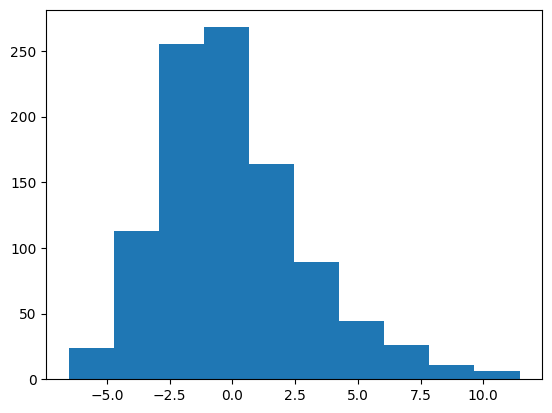

In [ ]:
plt.hist(X[0])

In [ ]:
X = GPU_data(X)
Y = GPU_data(Y)

In [ ]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [ ]:
def cross_entropy(outputs, labels):
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]

In [ ]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [ ]:
def Truncated_Normal(size):

    u1 = torch.rand(size)*(1-np.exp(-2)) + np.exp(-2)
    u2 = torch.rand(size)
    z  = torch.sqrt(-2*torch.log(u1)) * torch.cos(2*np.pi*u2)

    return z

In [ ]:
def acc(out,y):
    with torch.no_grad():
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [ ]:
X.shape

torch.Size([50, 1000])

In [ ]:
def get_batch(mode):
    b = c.b
    if mode == "train":
        r = np.random.randint(X.shape[0]-b)
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [ ]:
def model(x,w):

    return x@w[0]

In [ ]:
def make_plots():

    acc_train = acc(model(x,w),y)

    # xt,yt = get_batch('test')

    # acc_test = acc(model(xt,w),yt)

    wb.log({"acc_train": acc_train})

In [ ]:
wb.init(project="oh-ya");
c = wb.config

c.h = 0.001
c.b = 32
c.epochs = 100000

w = [GPU(Truncated_Normal((1000,2)))]

optimizer = torch.optim.Adam(w, lr=c.h)

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wb.log({"loss": loss})

    make_plots()


<ipython-input-2-13a1dae5b345>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=True, dtype=torch.float, device=device)
